### Reference catalogue 

### WorkFlow
----
#### Load lite.csv file > random sampling > get tile for sample location (function require) > select sources in each tile > update .csv files for each tile
----

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from spherical_geometry.polygon import SphericalPolygon
import matplotlib.pyplot as plt
import pandas as pd
import sys
from pathlib import Path
from scipy.optimize import minimize
import os
from astropy.io import ascii
import ligo.skymap.plot
import glob
import sds as dhutil
import healpy as hp

GAIA_ROOT_DIR = '/lyman/data1/factory/catalog/gaia_source_dr3/lite'

/home/snu/.local/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
cat_df = pd.DataFrame(columns=['path', 'ra', 'dec'])
cat_df['path'] = sorted(glob.glob(f'{GAIA_ROOT_DIR}/*.csv'))
cat_df['ra'] = [int(i.split('_')[5]) for i in cat_df['path']]
cat_df['dec'] = [int(i.split('_')[6].replace('.csv', '')) for i in cat_df['path']]
display(cat_df)

,path,ra,dec
0,/lyman/data1/factory/catalog/gaia_source_dr3/l...,100,-13
1,/lyman/data1/factory/catalog/gaia_source_dr3/l...,100,-24
2,/lyman/data1/factory/catalog/gaia_source_dr3/l...,100,-47
3,/lyman/data1/factory/catalog/gaia_source_dr3/l...,100,-53
4,/lyman/data1/factory/catalog/gaia_source_dr3/l...,100,-60
...,...,...,...
3076,/lyman/data1/factory/catalog/gaia_source_dr3/l...,99,15
3077,/lyman/data1/factory/catalog/gaia_source_dr3/l...,99,41
3078,/lyman/data1/factory/catalog/gaia_source_dr3/l...,99,5
3079,/lyman/data1/factory/catalog/gaia_source_dr3/l...,99,59


The point <SkyCoord (ICRS): (ra, dec) in deg
    (0., -90.)> is in tile 0.
10770 False [-0.66457797 -0.65851869 -2.19862417 -2.19256489]


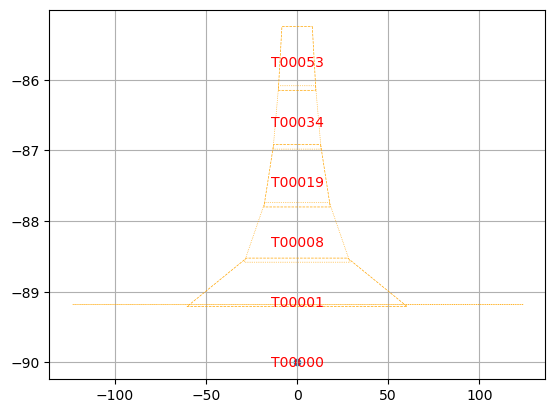

In [3]:
def path_set():
    path_thisfile = Path(os.path.abspath('')).resolve()
    path_src = path_thisfile.parent  # absolute path of dhutil
    path_root = path_src.parent  # parent of dhutil
    if path_root not in map(Path, sys.path):
        sys.path.append(str(path_root))
    return path_src


def get_tiles(indices, center=False):
    path_src = path_set()
    if center:
        center = ascii.read(str(path_src / "displaycenter.txt"))
        # center = ascii.read("/Users/dhhyun/VSCode/7DT/displaycenter.txt")
        return center[indices]
    vertices = ascii.read(str(path_src / "displayfootprint.txt"))
    # vertices = ascii.read("/Users/dhhyun/VSCode/7DT/displayfootprint.txt")
    return vertices[indices]


def tile_vertex(tile_num):
    tile_vertice = get_tiles(tile_num)
    tile_vertice = pd.DataFrame([tile_vertice], columns=tile_vertice.columns)
    indice = sorted(set([i[-1] for i in tile_vertice.columns]))

    for i in indice:
        sel_df = tile_vertice.filter(regex=f'{i}$', axis=1)
        sel_df = sel_df.rename(columns={key:key.replace(i, '') for key in list(sel_df.columns)})
        sel_df.index = [i]
        if i == indice[0]:
            idx_df = sel_df
        else:
            idx_df = pd.concat([idx_df, sel_df])
    
    return idx_df


def is_point_in_tile(point, tile_vertices):
    """
    Check if a point (SkyCoord) is inside a tile defined by its vertices.

    :param point: SkyCoord, the point to check.
    :param tile_vertices: List of SkyCoord, vertices of the tile in order.
    :return: Boolean, True if the point is inside the tile.
    """
    # Convert vertices to SphericalPolygon
    polygon = SphericalPolygon.from_lonlat(
        [v.ra.deg for v in tile_vertices],
        [v.dec.deg for v in tile_vertices]
    )

    # Check if the point is inside the polygon
    return polygon.contains_lonlat(point.ra.deg, point.dec.deg)


def load_tiles():
    table = ascii.read(str(path_set() / "displayfootprint.txt"))

    _tiles = []
    for i, row in enumerate(table):
        # Create SkyCoord objects for the four vertices
        vertices = [
            SkyCoord(ra=row[f"ra{j}"], dec=row[f"dec{j}"], unit='deg')
            for j in range(1, 5)
        ]
        # Append the tile dictionary to the list
        _tiles.append({
            'tile_id': i,  # Tile ID starting from 1
            'vertices': vertices
        })
    return _tiles


def find_tile_for_point(point, tiles):
    """
    Find which tile a point belongs to.

    :param point: SkyCoord, the point to check.
    :param tiles: List of dictionaries, where each dictionary contains:
                  - 'tile_id': int, identifier for the tile
                  - 'vertices': List of SkyCoord, vertices of the tile
    :return: The tile_id of the tile containing the point, or None if not found.
    """
    
    for tile in tiles:
        tile_id = tile['tile_id']
        tile_vertices = tile['vertices']

        if is_point_in_tile(point, tile_vertices):
            return tile_id
    return None


def is_points_in_ellipse_skycoord(points, ra_center, dec_center, a, b, theta):
    # Convert center and points to SkyCoord
    center = SkyCoord(ra=ra_center*u.deg, dec=dec_center*u.deg, frame='icrs')
    points = SkyCoord(ra=points[:, 0]*u.deg, dec=points[:, 1]*u.deg, frame='icrs')
    
    # Compute offsets in a rotated frame
    separation = points.separation(center).radian
    position_angle = points.position_angle(center).radian - np.radians(theta)
    
    # Convert to ellipse frame
    x = separation * np.cos(position_angle)
    y = separation * np.sin(position_angle)
    
    # Check ellipse condition
    return (x / a)**2 + (y / b)**2 <= 1


# minimum volume enclosing ellipse
def mvee(points, tol=1e-3):
    """
    Find the minimum volume enclosing ellipse (MVEE) for a set of 2D points.
    
    Parameters:
    - points: (n, 2) array of 2D points.
    - tol: Tolerance for stopping criterion.
    
    Returns:
    - Center of the ellipse.
    - Radii (semi-axes lengths) of the ellipse.
    - Rotation matrix of the ellipse.
    """
    points = np.array(points)
    n, d = points.shape
    Q = np.column_stack((points, np.ones(n)))
    
    # Initializations
    err = tol + 1.0
    u = np.ones(n) / n
    
    # Khachiyan Algorithm
    while err > tol:
        X = Q.T @ np.diag(u) @ Q
        M = np.diag(Q @ np.linalg.inv(X) @ Q.T)
        j = np.argmax(M)
        step_size = (M[j] - d - 1) / ((d + 1) * (M[j] - 1))
        new_u = (1 - step_size) * u
        new_u[j] += step_size
        err = np.linalg.norm(new_u - u)
        u = new_u

    # Center of the ellipse
    center = u @ points
    
    # Ellipse parameters
    A = np.linalg.inv(points.T @ np.diag(u) @ points - np.outer(center, center)) / d
    U, s, rotation = np.linalg.svd(A)
    radii = 1.0 / np.sqrt(s)
    
    return center, radii, rotation


# Example Usage
# load tiles 
_7dt_tiles = load_tiles()

# load point
test_point = SkyCoord(ra=360, dec=-90, unit='deg')

# find the tile which the point is located in
tile_id = find_tile_for_point(test_point, _7dt_tiles)
print(f"The point {test_point} is in tile {tile_id}.")

# Visualization
plt.figure(dpi=100)
ax = plt.axes()
ax.scatter(test_point.ra, test_point.dec, s=20)
ax.grid()
dhutil.overlay_tiles(fontsize=10)

In [4]:
tile = 2344
idx_df = tile_vertex(tile)
display(idx_df)

,ra,dec
1,328.960430,-61.515996
2,329.004339,-62.430764
3,326.033255,-62.430764
4,326.077164,-61.515996


In [5]:
_7dt_tiles = load_tiles()

In [6]:
test_point = SkyCoord(ra=360, dec=-90, unit='deg')

In [7]:
tile_id = find_tile_for_point(test_point, _7dt_tiles)
print(f"The point {test_point} is in tile {tile_id}.")

The point <SkyCoord (ICRS): (ra, dec) in deg
    (0., -90.)> is in tile 0.


10770 False [-0.66457797 -0.65851869 -2.19862417 -2.19256489]


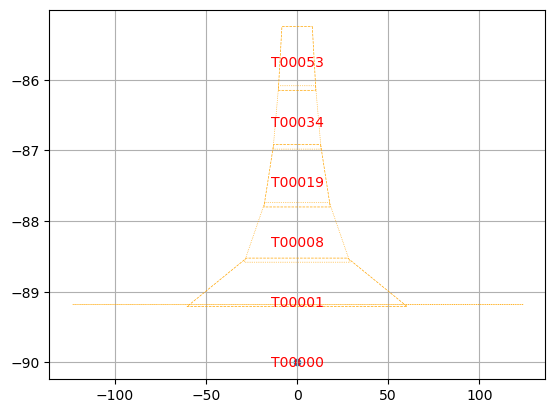

In [8]:
plt.figure(dpi=100)
ax = plt.axes()
# ax.plot([358, 2], [-25, -30])
ax.scatter(test_point.ra, test_point.dec, s=20)
ax.grid()
# ax.set_xlim(-4, 4)
# ax.set_ylim(-35, -22)
dhutil.overlay_tiles(fontsize=10)

In [9]:
# Example usage
ra = cat_df['ra'].to_numpy()
dec = cat_df['dec'].to_numpy()
points = np.column_stack((ra, dec))

ra_center = get_tiles(tile, center=True)['ra']
dec_center = get_tiles(tile, center=True)['dec']
a = 7 * np.pi / 180  # [deg]
b = 7 * np.pi / 180  # [deg]
print(ra_center, dec_center)

inside_mask = is_points_in_ellipse_skycoord(points, ra_center, dec_center, a, b, theta=0)
inside_points = points[inside_mask]

327.5187969924812 -61.9811320754717


In [10]:
for i, coord in enumerate(inside_points):
    co_ra = coord[0]; co_dec = coord[1]
    try:
        temp_df = pd.read_csv(f'{GAIA_ROOT_DIR}/gaia_dr3_lite_{co_ra}_{co_dec}.csv')
    except FileNotFoundError:  # exception for -0 > 0
        temp_df = pd.read_csv(f'{GAIA_ROOT_DIR}/gaia_dr3_lite_{co_ra}_-{co_dec}.csv')
    
    if i == 0:
        dr3 = temp_df
    else:
        dr3 = pd.concat([dr3, temp_df], axis=0)

display(dr3.columns)

Index(['ra', 'dec', 'ra_error', 'dec_error', 'pmra', 'pmdec', 'pmra_error',
       'pmdec_error', 'phot_g_mean_flux', 'phot_g_mean_flux_error',
       'phot_g_mean_mag', 'ref_epoch'],
      dtype='object')

[327.51910877 -61.98003745] [0.64676971 2.07050978] [[ 7.26478913e-05  9.99999997e-01]
 [ 9.99999997e-01 -7.26478913e-05]]


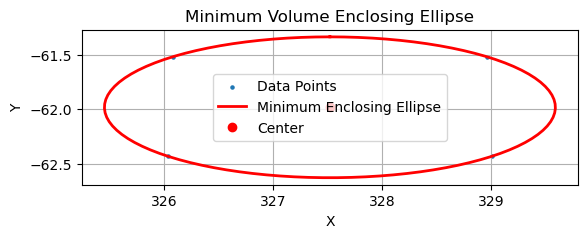

In [11]:
# points = np.random.rand(100, 2) * 10

ra = np.array(idx_df['ra'])
dec = np.array(idx_df['dec'])
points = np.vstack((ra, dec)).T
# sample_size = 1000
# sampled_points = points[np.random.choice(points.shape[0], sample_size, replace=False)]
center, radii, rotation = mvee(points)
print(center, radii, rotation)

# Generate points on a unit circle
theta = np.linspace(0, 2 * np.pi, 100)
circle = np.array([np.cos(theta), np.sin(theta)])  # Shape (2, 100)

# Scale by the radii (ellipse axes lengths)
ellipse = np.diag(radii) @ circle  # Shape (2, 100)

# Rotate by the rotation matrix
ellipse = rotation @ ellipse

# Shift by the center
ellipse[0, :] += center[0]
ellipse[1, :] += center[1]

# Plot the points and the ellipse
fig, ax = plt.subplots()
# fig = plt.figure()
# ax = fig.add_axes(111, projection='astro zoom', radius='1 deg')
ax.scatter(points[:, 0], points[:, 1], s=5, label="Data Points")
ax.plot(ellipse[0, :], ellipse[1, :], 'r-', linewidth=2, label="Minimum Enclosing Ellipse")
ax.plot(center[0], center[1], 'ro', label="Center")

# Set up plot appearance
ax.legend()
ax.set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Minimum Volume Enclosing Ellipse")
plt.grid()
plt.show()

163.17314393687792 -89.1741958739488 0.0
Total points Number: 2055509
Total points inside the ellipse: 0


/usr/local/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


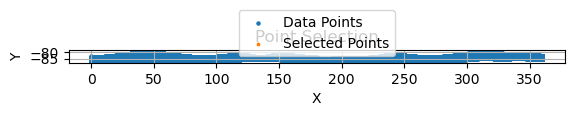

: 

In [ ]:
# Example usage
ra = dr3['ra'].to_numpy()
dec = dr3['dec'].to_numpy()
points = np.column_stack((ra, dec))

ra_center = center[0]
dec_center = center[1]
a = (radii[0] + 0.1) * np.pi / 180
b = (radii[1] + 0.1) * np.pi / 180
theta = 90 - np.degrees(np.arctan2(rotation[1, 0], rotation[0, 0]))
print(ra_center, dec_center, theta)

inside_mask = is_points_in_ellipse_skycoord(points, ra_center, dec_center, a, b, theta)
inside_points = points[inside_mask]
print(f"Total points Number: {len(points)}")
print(f"Total points inside the ellipse: {len(inside_points)}")

# Plot the points and the ellipse
fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], s=5, label="Data Points")
ax.scatter(inside_points[:, 0], inside_points[:, 1], s=3, label="Selected Points")

# Set up plot appearance
ax.legend()
ax.set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Point Selection")
plt.grid()
plt.show()

In [ ]:
def find_healpix_tile(tile_idx, matching_r):
    # get 7DT tile vertices
    idx_df = tile_vertex(tile_idx)
    
    # load healpix ids
    ipix_list = [s.split('_')[1] for s in sorted(glob.glob("files"))]
    dec_ra = [hp.pix2ang(64, ipix, nest=True, lonlat=True) for ipix in ipix_list]

    heal_df = pd.DataFrame(columns=['path', 'ra', 'dec'])
    heal_df['path'] = sorted(glob.glob("files"))
    heal_df['ra'] = np.array(dec_ra)[:,1]
    heal_df['dec'] = np.array(dec_ra)[:,0]

    heal_ra = heal_df['ra'].to_numpy()
    heal_dec = heal_df['dec'].to_numpy()
    heal_points = np.column_stack((heal_ra, heal_dec))

    # Get center of 7DT tile and set matching radius
    ra_center = get_tiles(tile_idx, center=True)['ra']
    dec_center = get_tiles(tile_idx, center=True)['dec']
    a = matching_r * np.pi / 180  # [deg]
    b = matching_r * np.pi / 180  # [deg]

    # find healpix tiles
    inside_h_mask = is_points_in_ellipse_skycoord(heal_points, ra_center, dec_center, a, b, theta=0)
    inside_h_points = heal_points[inside_h_mask]
    
    # merging selected healpix tiles
    for i, coord in enumerate(inside_h_points):
        co_ra = coord[0]; co_dec = coord[1]  # needs modification
        try:
            temp_df = pd.read_csv(f'{GAIA_ROOT_DIR}/gaia_dr3_lite_{co_ra}_{co_dec}.csv')
        except FileNotFoundError:  # exception for -0 > 0
            temp_df = pd.read_csv(f'{GAIA_ROOT_DIR}/gaia_dr3_lite_{co_ra}_-{co_dec}.csv')
        
        if i == 0:
            dr3 = temp_df
        else:
            dr3 = pd.concat([dr3, temp_df], axis=0)
        # returns merged healpix tile sources
        
    # elliptical fitting for 7DT tile
    tile_ra = np.array(idx_df['ra'])
    tile_dec = np.array(idx_df['dec'])
    tile_points = np.vstack((tile_ra, tile_dec)).T
    center, radii, rotation = mvee(tile_points)

    # Generate points on a unit circle
    theta = np.linspace(0, 2 * np.pi, 100)
    circle = np.array([np.cos(theta), np.sin(theta)])  # Shape (2, 100)

    # Scale by the radii (ellipse axes lengths)
    ellipse = np.diag(radii) @ circle  # Shape (2, 100)

    # Rotate by the rotation matrix
    ellipse = rotation @ ellipse

    # Shift by the center
    ellipse[0, :] += center[0]
    ellipse[1, :] += center[1]
    
    ra = dr3['ra'].to_numpy()
    dec = dr3['dec'].to_numpy()
    points = np.column_stack((ra, dec))

    ra_center = center[0]
    dec_center = center[1]
    a = (radii[0] + 0.1) * np.pi / 180
    b = (radii[1] + 0.1) * np.pi / 180
    theta = 90 - np.degrees(np.arctan2(rotation[1, 0], rotation[0, 0]))

    inside_mask = is_points_in_ellipse_skycoord(points, ra_center, dec_center, a, b, theta)
    inside_points = points[inside_mask]
    columns_to_extract = [
        "ra",
        "dec",
        "ra_error",
        "dec_error",
        "pmra",
        "pmdec",
        "pmra_error",
        "pmdec_error",
        "phot_g_mean_flux",
        "phot_g_mean_flux_error",
        "phot_g_mean_mag",  # CAUTION: its error should be derived later
        "ref_epoch"
    ]

    filtered_data = inside_points[columns_to_extract]
    
    print(f"Total points Number: {len(points)}")
    print(f"Total points inside the ellipse: {len(filtered_data)}")
    return filtered_data